In [2]:
import os 
import matplotlib as plt
import PIL as Image 
import numpy as np
import tensorflow as tf

from tensorflow.keras import layers , Model, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split


import pandas as pd
import cv2

In [9]:
import tifffile

In [10]:
import imageio.v3 as iio
import matplotlib.pyplot as plt

Image shape: (128, 128, 12)


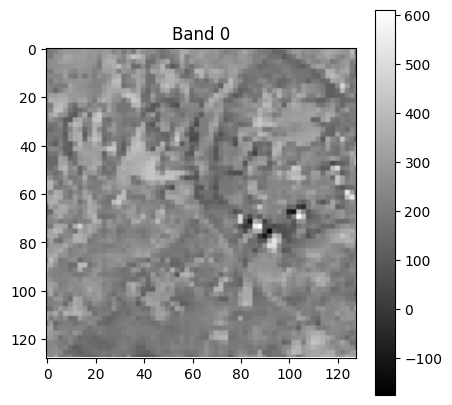

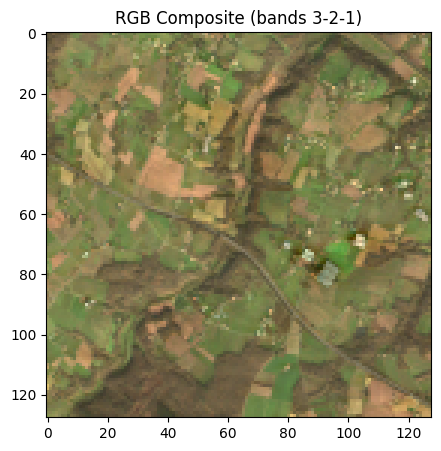

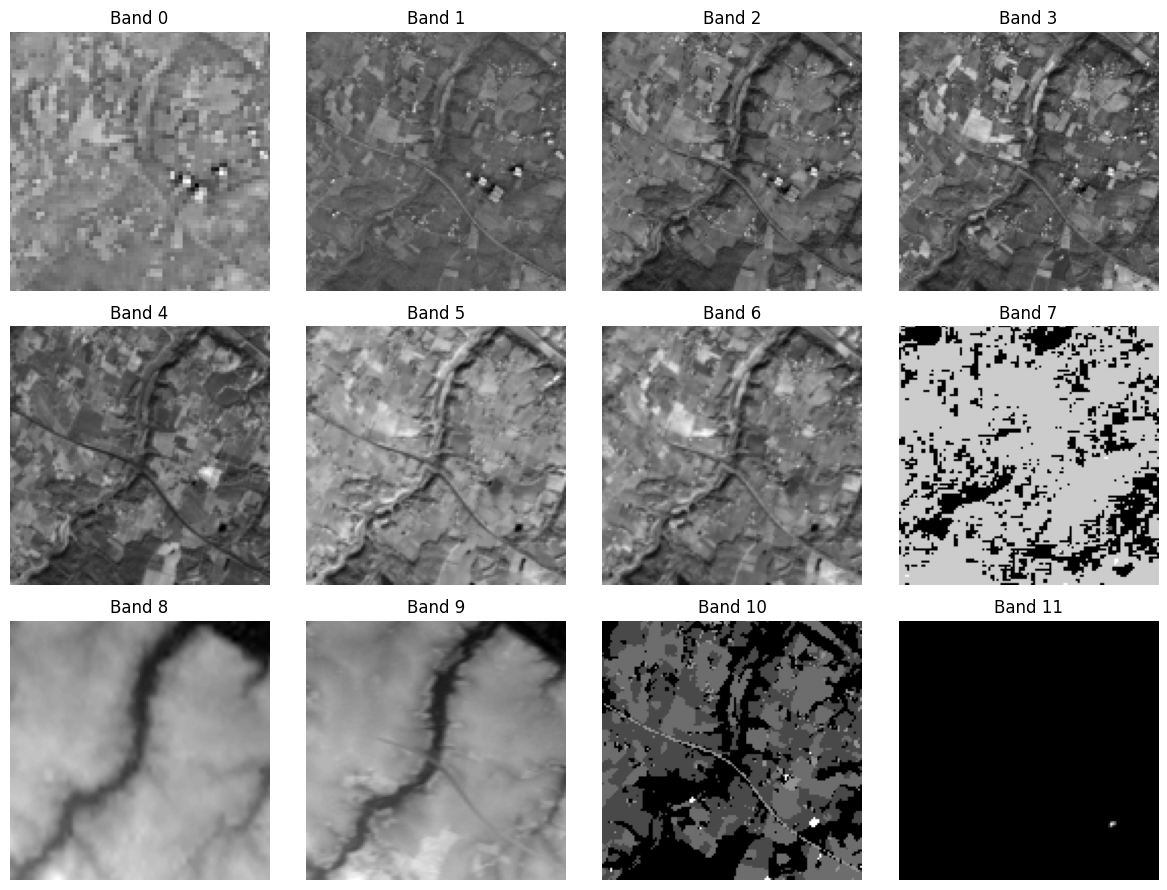

In [11]:
path = r"D:\cellula\task_2\data\images\7.tif"
img = tifffile.imread(path).astype(np.float32)  # shape (H, W, C)

print("Image shape:", img.shape)

# 1. Show a single band (e.g., band 0)
plt.figure(figsize=(5,5))
plt.imshow(img[:,:,0], cmap="gray")
plt.title("Band 0")
plt.colorbar()
plt.show()

# 2. Make an RGB composite (choose 3 bands, e.g., [3,2,1])
# NOTE: adjust band numbers depending on dataset
rgb = img[:,:, [3,2,1]]
rgb = (rgb - rgb.min()) / (rgb.max() - rgb.min())  # normalize to [0,1]

plt.figure(figsize=(5,5))
plt.imshow(rgb)
plt.title("RGB Composite (bands 3-2-1)")
plt.show()

# 3. Display all 12 bands in a grid
fig, axes = plt.subplots(3, 4, figsize=(12,9))
for i in range(12):
    ax = axes[i//4, i%4]
    ax.imshow(img[:,:,i], cmap="gray")
    ax.set_title(f"Band {i}")
    ax.axis("off")
plt.tight_layout()
plt.show()

In [12]:
import os
import tifffile
from PIL import Image
import numpy as np

input_dir = r"D:\cellula\task_2\data\images"
output_dir = r"D:\cellula\task_2\data\images_png"
os.makedirs(output_dir, exist_ok=True)

for file in os.listdir(input_dir):
    if file.endswith(".tif"):
        # Read with tifffile
        img = tifffile.imread(os.path.join(input_dir, file))

        # If multi-channel, take first 3 channels
        if img.ndim == 2:
            img = np.stack([img]*3, axis=-1)
        elif img.ndim == 3 and img.shape[-1] > 3:
            img = img[..., :3]

        # Convert to PIL Image and save as PNG
        img_pil = Image.fromarray((img / img.max() * 255).astype(np.uint8))
        img_pil.save(os.path.join(output_dir, file.replace(".tif", ".png")))


In [13]:
train_image_dir=r"D:\cellula\task_2\data\images_png"
train_mask_dir=r"D:\cellula\task_2\data\labels"

In [14]:
import tifffile
import imageio.v3 as iio
import matplotlib.pyplot as plt
import numpy as np
def disblay_image_and_mask(img_path,img_mask):

    img = tifffile.imread(img_path).astype(np.float32)

    mask=Image.open(img_mask)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    axes[0].imshow(img[:, :, 0], cmap="gray")
    axes[0].set_title("Image (Band 0)")
    axes[0].axis('off')

    axes[1].imshow(mask, cmap="gray")
    axes[1].set_title("Segmentation Mask")
    axes[1].axis('off')

    plt.show()

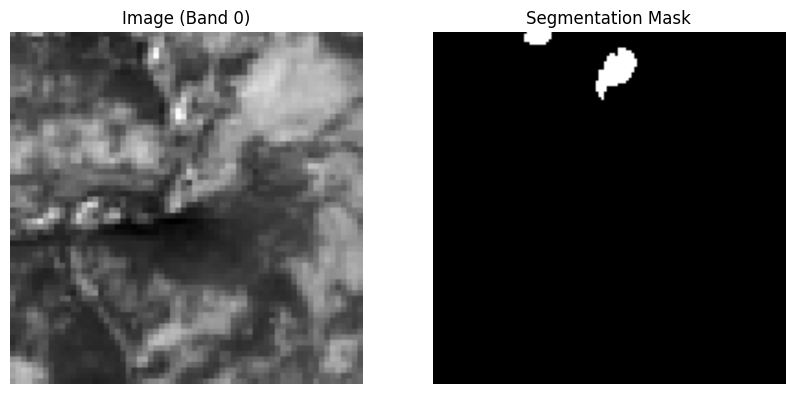

In [15]:
from PIL import Image
disblay_image_and_mask(r"D:\cellula\task_2\data\images\13.tif",r"D:\cellula\task_2\data\labels\13.png")

In [16]:


def display_image_and_mask(img_path, mask_path):
    # Load multispectral image (12 bands)
    img = tifffile.imread(img_path).astype(np.float32)

    # Load binary mask
    mask = iio.imread(mask_path).astype(np.int32)

    # Plot side by side
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Show one band (e.g., band 0 of the .tif image)
    axes[0].imshow(img[:, :, 0], cmap="gray")
    axes[0].set_title("Image (Band 0)")

    # Show mask
    axes[1].imshow(mask, cmap="gray")
    axes[1].set_title("Segmentation Mask")

    plt.show()


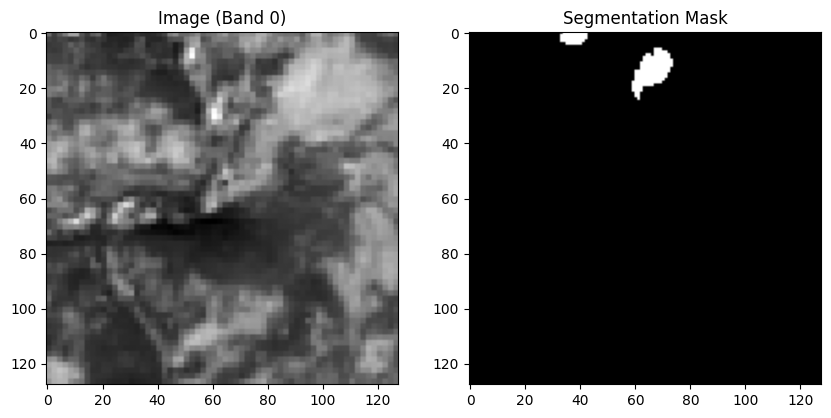

In [17]:
display_image_and_mask(
    r"D:\cellula\task_2\data\images\13.tif",
    r"D:\cellula\task_2\data\labels\13.png"
)


In [18]:
train_img_files=sorted(os.listdir(train_image_dir))
train_mask_files=sorted(os.listdir(train_mask_dir))

In [19]:
if len(train_img_files) != len(train_mask_files):
    print("error: the images and masks do not match")
else:
    for img_file , mask_file in zip(train_img_files[:5],train_mask_files[:5]):
        img_path=os.path.join(train_image_dir,img_file)
        mask_path=os.path.join(train_mask_dir,mask_file)


        disblay_image_and_mask(img_path,mask_path)



TiffFileError: not a TIFF file b'\x89PNG'

In [20]:
images= [os.path.join(train_image_dir, file) for file in os.listdir(train_image_dir)]
masks= [os.path.join(train_mask_dir, file) for file in os.listdir(train_mask_dir)]

data = pd.DataFrame({"image":images, "mask":masks})
train_df , val_df =train_test_split(data , train_size=0.8 ,shuffle=True , random_state=123)

In [21]:
image_datagen=ImageDataGenerator(rescale=1/255)
mask_datagen=ImageDataGenerator(rescale=1/255)

In [22]:
def create_generator(image_generator, mask_generator, batch_size=16):
    while True:
        for (img_batch,mask_batch) in zip(image_generator,mask_generator):
            yield img_batch, mask_batch

In [23]:
train_image_generator = image_datagen.flow_from_dataframe(
    dataframe = train_df,
    x_col ="image",
    y_col=None,
    target_size=(128,128),
    batch_size=16,
    class_mode=None,
    color_mode="rgb",
    shuffle=True,
    seed=42
)

train_mask_generator = mask_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col ="mask",
    y_col=None,
    target_size=(128,128),
    batch_size=16,
    class_mode=None,
    color_mode="grayscale",
    shuffle=True,
    seed=42   
)


train_generator = create_generator(train_image_generator, train_mask_generator)
# or same use  val_generator = zip(val_image_generator, val_mask_generator)

Found 244 validated image filenames.
Found 244 validated image filenames.


In [24]:
imgs, masks = next(train_generator)
print("Images range:", imgs.min(), imgs.max())
print("Masks unique:", np.unique(masks))

Images range: 0.0 1.0
Masks unique: [0.         0.00392157]


In [25]:
val_image_generator=image_datagen.flow_from_dataframe(
    dataframe = val_df,
    x_col ="image",
    y_col=None,
    target_size=(128,128),
    batch_size=16,
    class_mode=None,
    color_mode="rgb",
    shuffle=False,
    seed=42
)

val_mask_generator=mask_datagen.flow_from_dataframe(
    dataframe = val_df,
    x_col ="mask",
    y_col=None,
    target_size=(128,128),
    batch_size=16,
    class_mode=None,
    color_mode="grayscale",
    shuffle=False,
    seed=42
)

val_generator = create_generator(val_image_generator, val_mask_generator)

Found 62 validated image filenames.
Found 62 validated image filenames.


In [26]:
imgs, masks = next(val_generator)
print("Images range:", imgs.min(), imgs.max())
print("Masks unique:", np.unique(masks))


Images range: 0.0 1.0
Masks unique: [0.         0.00392157]


In [5]:
def unet_model(input_size=(128,128)):
    inputs =Input(input_size)


    c1 =layers.Conv2D(64, (3,3), activation="relu", padding="same")(inputs)
    c1 =layers.Conv2D(64, (3,3), activation="relu", padding="same")(c1)
    p1 =layers.MaxPooling2D( (2,2) )(c1)

    c2 =layers.Conv2D(128, (3,3), activation="relu", padding="same")(p1)
    c2 =layers.Conv2D(128, (3,3), activation="relu", padding="same")(c2)
    p2 =layers.MaxPooling2D( (2,2) )(c2)

    c3 =layers.Conv2D(256, (3,3), activation="relu", padding="same")(p2)
    c3 =layers.Conv2D(256, (3,3), activation="relu", padding="same")(c3)
    p3 =layers.MaxPooling2D( (2,2) )(c3)

    c4 =layers.Conv2D(512, (3,3), activation="relu", padding="same")(p3)
    c4 =layers.Conv2D(512, (3,3), activation="relu", padding="same")(c4)
    p4 =layers.MaxPooling2D( (2,2) )(c4)   


    c5 =layers.Conv2D(1024, (3,3), activation="relu", padding="same")(p4)
    c5 =layers.Conv2D(1024, (3,3), activation="relu", padding="same")(c5)
  
 # decoder

    u6 =layers.Conv2DTranspose(512, (2,2), strides=(2,2), padding="same")(c5)
    #u6 =layers.Concatenate([u6 , c4])
    u6 = layers.Concatenate()([u6, c4])
    c6 =layers.Conv2D(512, (3,3), activation="relu", padding="same")(u6)
    c6 =layers.Conv2D(512, (3,3), activation="relu", padding="same")(c6)

    u7 =layers.Conv2DTranspose(256, (2,2), strides=(2,2), padding="same")(c6)
    #u7 =layers.Concatenate([u7 , c3])
    u7 = layers.Concatenate()([u7, c3])
    c7 =layers.Conv2D(256, (3,3), activation="relu", padding="same")(u7)
    c7 =layers.Conv2D(256, (3,3), activation="relu", padding="same")(c7)

    u8 =layers.Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c7)
    #u8 =layers.Concatenate([u8 , c2])
    u8 = layers.Concatenate()([u8, c2])
    c8 =layers.Conv2D(128, (3,3), activation="relu", padding="same")(u8)
    c8 =layers.Conv2D(128, (3,3), activation="relu", padding="same")(c8)

    u9 =layers.Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c8)
    #u9 =layers.Concatenate([u9 , c1])
    u9 = layers.Concatenate()([u9, c1])
    c9 =layers.Conv2D(64, (3,3), activation="relu", padding="same")(u9)
    c9 =layers.Conv2D(64, (3,3), activation="relu", padding="same")(c9)  

    #output layer


    outputs= layers.Conv2D(1, (1,1), activation="sigmoid")(c9)


    model = Model(inputs=[inputs], outputs= [outputs])

    return model  

In [6]:
model = unet_model(input_size=(128, 128, 3))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#model.summary()


In [29]:
history = model.fit(
train_generator,
validation_data=val_generator,
epochs=5,
steps_per_epoch=len(train_df)//16,
validation_steps=len(val_df) //16

)

Epoch 1/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 591ms/step - accuracy: 0.7514 - loss: 0.1556 - val_accuracy: 0.7033 - val_loss: 0.0129
Epoch 2/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 549ms/step - accuracy: 0.7308 - loss: 0.0132 - val_accuracy: 0.7911 - val_loss: 0.0088
Epoch 3/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 574ms/step - accuracy: 0.7444 - loss: 0.0107 - val_accuracy: 0.7033 - val_loss: 0.0098
Epoch 4/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 594ms/step - accuracy: 0.7457 - loss: 0.0086 - val_accuracy: 0.7911 - val_loss: 0.0069
Epoch 5/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 609ms/step - accuracy: 0.7452 - loss: 0.0081 - val_accuracy: 0.7033 - val_loss: 0.0090


In [76]:
import tensorflow as tf

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', dice_coef])


In [93]:
history = model.fit(
train_generator,
validation_data=val_generator,
epochs=5,
steps_per_epoch=len(train_df)//16,
validation_steps=len(val_df) //16

)

Epoch 1/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 584ms/step - accuracy: 0.7416 - dice_coef: 0.0037 - loss: 0.0079 - val_accuracy: 0.6812 - val_dice_coef: 0.0033 - val_loss: 0.0094
Epoch 2/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 542ms/step - accuracy: 0.7389 - dice_coef: 0.0035 - loss: 0.0079 - val_accuracy: 0.6148 - val_dice_coef: 0.0033 - val_loss: 0.0110
Epoch 3/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 540ms/step - accuracy: 0.7373 - dice_coef: 0.0037 - loss: 0.0080 - val_accuracy: 0.6812 - val_dice_coef: 0.0034 - val_loss: 0.0095
Epoch 4/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 542ms/step - accuracy: 0.7664 - dice_coef: 0.0039 - loss: 0.0072 - val_accuracy: 0.6148 - val_dice_coef: 0.0032 - val_loss: 0.0111
Epoch 5/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 545ms/step - accuracy: 0.7191 - dice_coef: 0.0037 - loss: 0.0084 - val_accuracy: 0.6812 - val_dice_coef: 0.0034 - val_loss: 0.0095


In [94]:
model.save("unet_model_segmentation.h5")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step


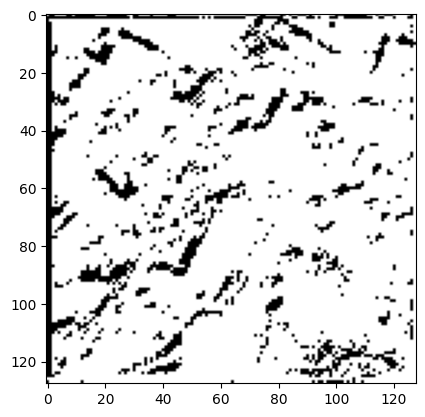

In [27]:
images, masks = next(val_generator)  # get first batch
pred = model.predict(images)

import matplotlib.pyplot as plt
plt.imshow(pred[0, ..., 0] > 0.5, cmap='gray')  # threshold to binary
plt.show()

In [96]:
images, masks = next(val_generator)
pred = model.predict(images)

print("Pred min/max:", pred.min(), pred.max())
print("Masks min/max:", masks.min(), masks.max())


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
Pred min/max: 7.248332e-06 0.003945877
Masks min/max: 0.0 0.003921569


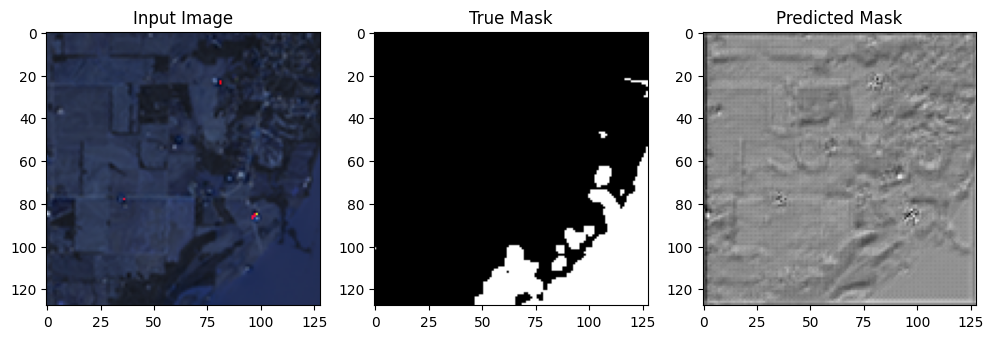

In [31]:
plt.figure(figsize=(12,4))

# Input image
plt.subplot(1,3,1)
plt.imshow(images[3])
plt.title("Input Image")

# Ground truth mask
plt.subplot(1,3,2)
plt.imshow(masks[3,...,0], cmap='gray')
plt.title("True Mask")

# Predicted mask
plt.subplot(1,3,3)
plt.imshow(pred[3,...,0], cmap='gray')  # no threshold yet
plt.title("Predicted Mask")

plt.show()


In [101]:
import tensorflow as tf

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


In [104]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # or use a dice loss
    metrics=[dice_coef]
)


In [106]:
def dice_loss(y_true, y_pred):
    smooth = 1e-6
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2.*intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

model.compile(optimizer='adam', loss=dice_loss, metrics=[dice_coef])


In [107]:
history = model.fit(
train_generator,
validation_data=val_generator,
epochs=5,
steps_per_epoch=len(train_df)//16,
validation_steps=len(val_df) //16

)

Epoch 1/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 579ms/step - dice_coef: 0.0020 - loss: 0.9980 - val_dice_coef: 0.0020 - val_loss: 0.9980
Epoch 2/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 543ms/step - dice_coef: 0.0024 - loss: 0.9976 - val_dice_coef: 0.0022 - val_loss: 0.9978
Epoch 3/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 547ms/step - dice_coef: 0.0028 - loss: 0.9972 - val_dice_coef: 0.0039 - val_loss: 0.9961
Epoch 4/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 561ms/step - dice_coef: 0.0038 - loss: 0.9961 - val_dice_coef: 0.0055 - val_loss: 0.9945
Epoch 5/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 563ms/step - dice_coef: 0.0029 - loss: 0.9970 - val_dice_coef: 0.0048 - val_loss: 0.9952
